# Support Vector Regressor
by Cesar Malenab

### Declarations

In [50]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import shap

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR, LinearSVR

from yellowbrick.regressor import ResidualsPlot, PredictionError

from joblib import dump, load

shap.initjs()

pd.set_option('display.max_columns', None)

### Data Import

In [2]:
df = pd.read_csv('data/fire_resistance.csv')
df = df.set_index('beam_name')

In [3]:
df.head()

,length,concrete_area,concrete_cover,steel_area,frp_area,insulation_thickness,insulation_depth,conc_strength,steel_strength,frp_strength,glass_transition,thermal_conductivity,specific_heat,total_load,load_ratio,fire_resistance
beam_name,,,,,,,,,,,,,,,,
B1,3000,60000,25,402.1,0.0,0.0,0.0,47.6,591,0,0,0.000,0,61.2,44.8,90
B2,3000,60000,25,402.1,0.0,0.0,0.0,45.5,591,0,0,0.000,0,61.2,44.8,90
B3,3000,60000,25,402.1,120.0,25.0,0.0,44.4,591,2800,52,0.175,730800,81.2,38.4,76
B4,3000,60000,25,402.1,120.0,40.0,80.0,47.4,591,2800,52,0.175,730800,81.2,38.4,90
B5,3000,60000,25,402.1,120.0,25.0,80.0,45.1,591,2800,52,0.175,730800,81.2,38.4,92


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21434 entries, B1 to I5_ B4488
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   length                21434 non-null  int64  
 1   concrete_area         21434 non-null  int64  
 2   concrete_cover        21434 non-null  int64  
 3   steel_area            21434 non-null  float64
 4   frp_area              21434 non-null  float64
 5   insulation_thickness  21434 non-null  float64
 6   insulation_depth      21434 non-null  float64
 7   conc_strength         21434 non-null  float64
 8   steel_strength        21434 non-null  int64  
 9   frp_strength          21434 non-null  int64  
 10  glass_transition      21434 non-null  int64  
 11  thermal_conductivity  21434 non-null  float64
 12  specific_heat         21434 non-null  int64  
 13  total_load            21434 non-null  float64
 14  load_ratio            21434 non-null  float64
 15  fire_resistance    

### Train-test Split

In [5]:
X = df.drop('fire_resistance', axis=1)
y = df['fire_resistance']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(18218, 15)
(18218,)
(3216, 15)
(3216,)


In [8]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Support Vector Regressor Model

### Initial base model:

In [13]:
svr = SVR(kernel='rbf', C=1, gamma=0.5)

In [14]:
svr.fit(X_train, y_train)

SVR(C=1, gamma=0.5)

In [15]:
y_preds = svr.predict(X_test)

In [16]:
rmse = np.sqrt(mean_squared_error(y_test, y_preds))
mae = mean_absolute_error(y_test, y_preds)

In [17]:
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 52.29027134731914
RMSE: 71.7057337102795


### Random Search of best parameters

In [30]:
svr = SVR()

param_dist = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.5, 1, 5, 10, 15, 100, 500, 1000],
    'degree': [2,3,4,5],  # For polynomial kernel
#     'coef0': [0.01, 0.5, 0.1, 1, 5, 10],  # For polynomial and sigmoid kernels (did not include due to long training time)
    'gamma': ['scale', 'auto'],  # For RBF kernel
    'epsilon': [0.1, 0.5, 1]
}

In [31]:
random_svr = RandomizedSearchCV(estimator=svr, 
                                param_distributions=param_dist, 
                                n_iter=100, 
                                cv=5, 
                                scoring='neg_mean_squared_error', 
                                random_state=42,
                                verbose=2)


In [32]:
start_time = time.time()

random_svr.fit(X_train, y_train)

duration = time.time() - start_time

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END C=500, degree=5, epsilon=1, gamma=auto, kernel=linear; total time= 2.0min
[CV] END C=500, degree=5, epsilon=1, gamma=auto, kernel=linear; total time= 2.1min
[CV] END C=500, degree=5, epsilon=1, gamma=auto, kernel=linear; total time= 2.0min
[CV] END C=500, degree=5, epsilon=1, gamma=auto, kernel=linear; total time= 2.1min
[CV] END C=500, degree=5, epsilon=1, gamma=auto, kernel=linear; total time= 2.0min
[CV] END C=10, degree=3, epsilon=0.5, gamma=auto, kernel=linear; total time=   8.8s
[CV] END C=10, degree=3, epsilon=0.5, gamma=auto, kernel=linear; total time=   8.8s
[CV] END C=10, degree=3, epsilon=0.5, gamma=auto, kernel=linear; total time=   8.8s
[CV] END C=10, degree=3, epsilon=0.5, gamma=auto, kernel=linear; total time=   8.7s
[CV] END C=10, degree=3, epsilon=0.5, gamma=auto, kernel=linear; total time=   8.8s
[CV] END C=500, degree=4, epsilon=0.1, gamma=scale, kernel=linear; total time= 2.1min
[CV] END C=500, 

[CV] END ..C=5, degree=2, epsilon=1, gamma=auto, kernel=poly; total time=   6.3s
[CV] END ..C=5, degree=2, epsilon=1, gamma=auto, kernel=poly; total time=   6.3s
[CV] END C=500, degree=4, epsilon=0.5, gamma=auto, kernel=linear; total time= 2.1min
[CV] END C=500, degree=4, epsilon=0.5, gamma=auto, kernel=linear; total time= 2.1min
[CV] END C=500, degree=4, epsilon=0.5, gamma=auto, kernel=linear; total time= 2.0min
[CV] END C=500, degree=4, epsilon=0.5, gamma=auto, kernel=linear; total time= 2.2min
[CV] END C=500, degree=4, epsilon=0.5, gamma=auto, kernel=linear; total time= 2.1min
[CV] END C=100, degree=4, epsilon=1, gamma=scale, kernel=linear; total time=  32.8s
[CV] END C=100, degree=4, epsilon=1, gamma=scale, kernel=linear; total time=  31.7s
[CV] END C=100, degree=4, epsilon=1, gamma=scale, kernel=linear; total time=  33.9s
[CV] END C=100, degree=4, epsilon=1, gamma=scale, kernel=linear; total time=  32.7s
[CV] END C=100, degree=4, epsilon=1, gamma=scale, kernel=linear; total time= 

[CV] END C=0.5, degree=5, epsilon=0.1, gamma=auto, kernel=rbf; total time=  11.3s
[CV] END C=0.5, degree=5, epsilon=0.1, gamma=auto, kernel=rbf; total time=  11.3s
[CV] END C=0.5, degree=5, epsilon=0.1, gamma=auto, kernel=rbf; total time=  11.3s
[CV] END C=100, degree=2, epsilon=0.1, gamma=scale, kernel=rbf; total time=  19.0s
[CV] END C=100, degree=2, epsilon=0.1, gamma=scale, kernel=rbf; total time=  19.0s
[CV] END C=100, degree=2, epsilon=0.1, gamma=scale, kernel=rbf; total time=  19.6s
[CV] END C=100, degree=2, epsilon=0.1, gamma=scale, kernel=rbf; total time=  19.0s
[CV] END C=100, degree=2, epsilon=0.1, gamma=scale, kernel=rbf; total time=  18.8s
[CV] END C=15, degree=5, epsilon=0.1, gamma=scale, kernel=linear; total time=  10.6s
[CV] END C=15, degree=5, epsilon=0.1, gamma=scale, kernel=linear; total time=  10.5s
[CV] END C=15, degree=5, epsilon=0.1, gamma=scale, kernel=linear; total time=  10.6s
[CV] END C=15, degree=5, epsilon=0.1, gamma=scale, kernel=linear; total time=  10.5s

[CV] END C=15, degree=2, epsilon=1, gamma=auto, kernel=linear; total time=  10.4s
[CV] END C=15, degree=2, epsilon=1, gamma=auto, kernel=linear; total time=  10.2s
[CV] END C=15, degree=2, epsilon=1, gamma=auto, kernel=linear; total time=  10.1s
[CV] END C=15, degree=2, epsilon=1, gamma=auto, kernel=linear; total time=  10.4s
[CV] END C=15, degree=2, epsilon=1, gamma=auto, kernel=linear; total time=  10.3s
[CV] END C=1000, degree=5, epsilon=0.5, gamma=scale, kernel=rbf; total time= 4.3min
[CV] END C=1000, degree=5, epsilon=0.5, gamma=scale, kernel=rbf; total time= 3.8min
[CV] END C=1000, degree=5, epsilon=0.5, gamma=scale, kernel=rbf; total time= 4.5min
[CV] END C=1000, degree=5, epsilon=0.5, gamma=scale, kernel=rbf; total time= 4.2min
[CV] END C=1000, degree=5, epsilon=0.5, gamma=scale, kernel=rbf; total time= 4.0min
[CV] END C=1000, degree=5, epsilon=1, gamma=auto, kernel=linear; total time= 3.9min
[CV] END C=1000, degree=5, epsilon=1, gamma=auto, kernel=linear; total time= 3.8min
[C

[CV] END C=100, degree=4, epsilon=0.1, gamma=scale, kernel=linear; total time=  32.8s
[CV] END C=100, degree=4, epsilon=0.1, gamma=scale, kernel=linear; total time=  34.7s
[CV] END C=0.5, degree=2, epsilon=0.5, gamma=scale, kernel=rbf; total time=  11.3s
[CV] END C=0.5, degree=2, epsilon=0.5, gamma=scale, kernel=rbf; total time=  11.0s
[CV] END C=0.5, degree=2, epsilon=0.5, gamma=scale, kernel=rbf; total time=  11.1s
[CV] END C=0.5, degree=2, epsilon=0.5, gamma=scale, kernel=rbf; total time=  11.0s
[CV] END C=0.5, degree=2, epsilon=0.5, gamma=scale, kernel=rbf; total time=  11.3s
[CV] END C=5, degree=2, epsilon=0.1, gamma=scale, kernel=linear; total time=   7.5s
[CV] END C=5, degree=2, epsilon=0.1, gamma=scale, kernel=linear; total time=   7.2s
[CV] END C=5, degree=2, epsilon=0.1, gamma=scale, kernel=linear; total time=   7.6s
[CV] END C=5, degree=2, epsilon=0.1, gamma=scale, kernel=linear; total time=   7.3s
[CV] END C=5, degree=2, epsilon=0.1, gamma=scale, kernel=linear; total time= 

[CV] END C=5, degree=3, epsilon=0.1, gamma=auto, kernel=linear; total time=   7.3s
[CV] END C=5, degree=3, epsilon=0.1, gamma=auto, kernel=linear; total time=   7.5s
[CV] END C=0.5, degree=5, epsilon=0.1, gamma=auto, kernel=linear; total time=   6.1s
[CV] END C=0.5, degree=5, epsilon=0.1, gamma=auto, kernel=linear; total time=   5.9s
[CV] END C=0.5, degree=5, epsilon=0.1, gamma=auto, kernel=linear; total time=   5.9s
[CV] END C=0.5, degree=5, epsilon=0.1, gamma=auto, kernel=linear; total time=   5.9s
[CV] END C=0.5, degree=5, epsilon=0.1, gamma=auto, kernel=linear; total time=   5.9s


In [33]:
print(f"Training took {duration/60} minutes.")

Training took 352.56398542722064 minutes.


In [34]:
y_preds = random_svr.predict(X_test)

In [35]:
rmse = np.sqrt(mean_squared_error(y_test, y_preds))
mae = mean_absolute_error(y_test, y_preds)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 14.717768673911168
RMSE: 26.49442642312295


In [36]:
random_svr.best_params_

{'kernel': 'rbf', 'gamma': 'scale', 'epsilon': 1, 'degree': 2, 'C': 1000}

In [37]:
pd.DataFrame(random_svr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel,param_gamma,param_epsilon,param_degree,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,121.975974,1.710009,0.761234,0.011887,linear,auto,1,5,500,"{'kernel': 'linear', 'gamma': 'auto', 'epsilon...",-1850.567447,-1839.298329,-1812.914841,-1836.110785,-1813.479925,-1830.474266,14.903096,44
1,8.139138,0.031279,0.757478,0.006065,linear,auto,0.5,3,10,"{'kernel': 'linear', 'gamma': 'auto', 'epsilon...",-1850.253404,-1839.007057,-1812.417844,-1836.522220,-1813.783907,-1830.396886,14.867233,26
2,123.634866,2.345501,0.771267,0.005087,linear,scale,0.1,4,500,"{'kernel': 'linear', 'gamma': 'scale', 'epsilo...",-1850.735228,-1838.954545,-1812.774437,-1836.672323,-1814.445646,-1830.716436,14.769868,53
3,241.800654,5.563891,3.992369,0.011227,rbf,scale,1,2,1000,"{'kernel': 'rbf', 'gamma': 'scale', 'epsilon':...",-747.767950,-755.369026,-703.156975,-831.907709,-687.483870,-745.137106,50.451914,1
4,34.214552,2.644731,0.868190,0.002143,poly,scale,1,5,15,"{'kernel': 'poly', 'gamma': 'scale', 'epsilon'...",-2032.322977,-7790.724012,-22207.938677,-18579.467334,-26622.351556,-15446.560911,9154.050977,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,7.553782,0.076534,4.269605,0.031498,rbf,auto,0.5,5,15,"{'kernel': 'rbf', 'gamma': 'auto', 'epsilon': ...",-1099.572349,-1082.067035,-1051.944402,-1139.157254,-1046.515836,-1083.851375,33.826234,8
96,7.072239,0.036050,4.275756,0.017860,rbf,scale,0.5,4,5,"{'kernel': 'rbf', 'gamma': 'scale', 'epsilon':...",-1220.978142,-1181.109313,-1171.048555,-1252.039862,-1166.999134,-1198.435001,32.924413,15
97,14.315654,0.358271,4.206304,0.023317,rbf,scale,0.5,2,100,"{'kernel': 'rbf', 'gamma': 'scale', 'epsilon':...",-918.434038,-914.372336,-875.387219,-979.338404,-859.616071,-909.429614,41.552431,6
98,6.713403,0.097781,0.780420,0.009417,linear,auto,0.1,3,5,"{'kernel': 'linear', 'gamma': 'auto', 'epsilon...",-1849.810098,-1838.704998,-1812.491551,-1836.619878,-1814.719119,-1830.469129,14.498210,35


### Training with best parameters:

In [9]:
svr = SVR(kernel='rbf',
         gamma='auto',
         degree=3,
         epsilon=1,
         C=1000)

In [10]:
svr.fit(X_train, y_train)

SVR(C=1000, epsilon=1, gamma='auto')

In [11]:
y_pred = svr.predict(X_test)

In [12]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
MAE = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {MAE}")
print(f"RMSE: {RMSE}")
print(f"r2: {r2}")

MAE: 14.717783242687222
RMSE: 26.494441541277308
r2: 0.8712963598604668


### Prediction Error

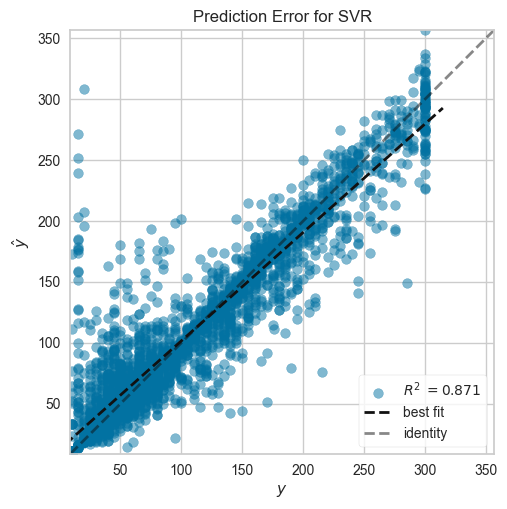

<Axes: title={'center': 'Prediction Error for SVR'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [43]:
pe_visualizer = PredictionError(svr, alpha=0.5)

pe_visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
pe_visualizer.score(X_test, y_test)  # Evaluate the model on the test data
pe_visualizer.show()  

### Residual Plots

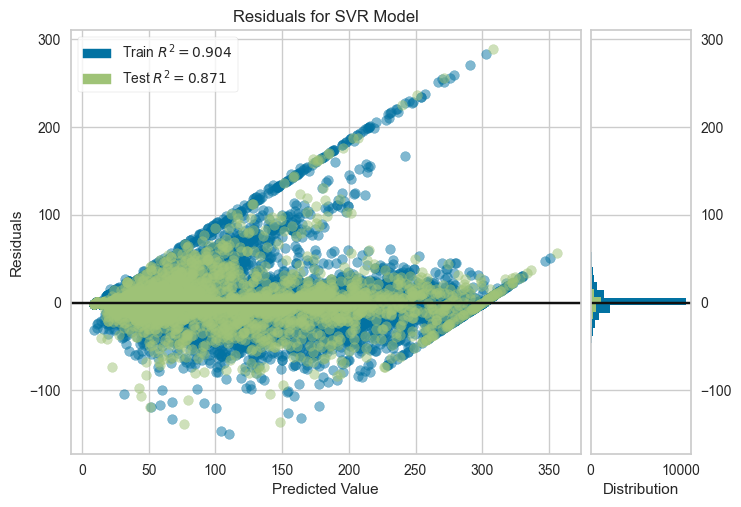

<Axes: title={'center': 'Residuals for SVR Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [14]:
rp_visualizer = ResidualsPlot(svr, train_alpha=0.5, test_alpha=0.5)

rp_visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
rp_visualizer.score(X_test, y_test)  # Evaluate the model on the test data
rp_visualizer.show()  

## Using SHAP for feature importance

In [39]:
explainer = shap.KernelExplainer(svr.predict, X_train[:50], feature_names=X.columns)

  0%|          | 0/15 [00:00<?, ?it/s]

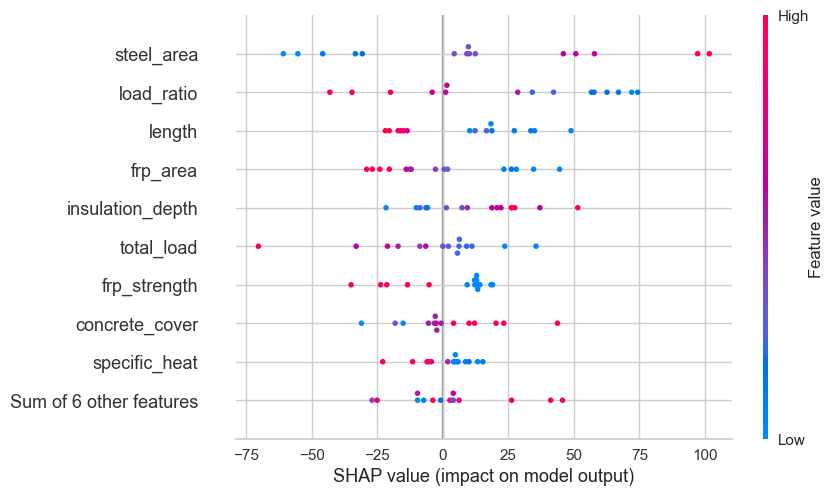

In [40]:
shap.plots.beeswarm(explainer(X_test[:15]))

  0%|          | 0/15 [00:00<?, ?it/s]

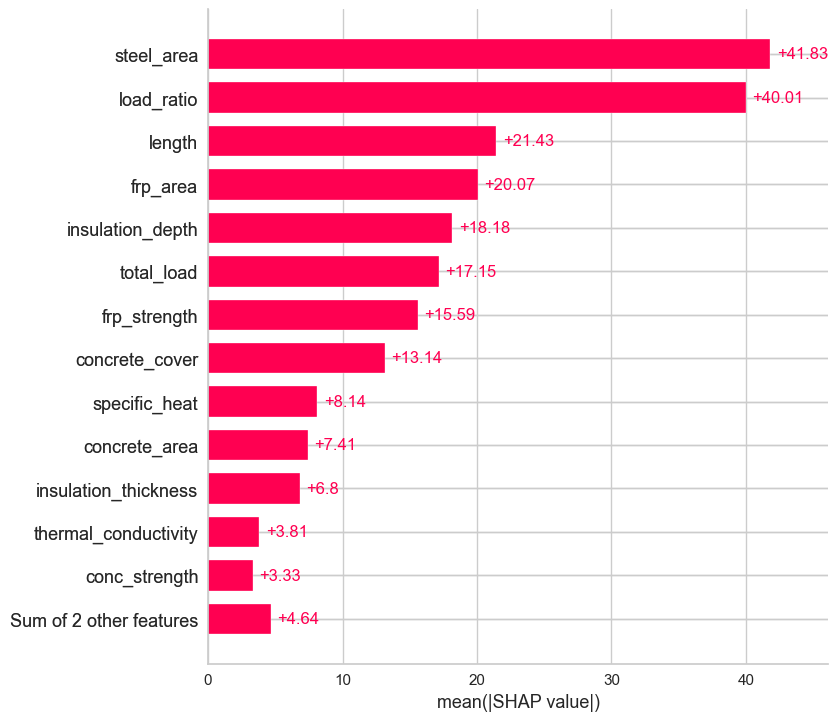

In [41]:
shap.plots.bar(explainer(X_test[:15]), max_display=14)

### SVR on experimental data

In [15]:
df_exp = df.head(50)

In [16]:
df_exp.head()

,length,concrete_area,concrete_cover,steel_area,frp_area,insulation_thickness,insulation_depth,conc_strength,steel_strength,frp_strength,glass_transition,thermal_conductivity,specific_heat,total_load,load_ratio,fire_resistance
beam_name,,,,,,,,,,,,,,,,
B1,3000,60000,25,402.1,0.0,0.0,0.0,47.6,591,0,0,0.000,0,61.2,44.8,90
B2,3000,60000,25,402.1,0.0,0.0,0.0,45.5,591,0,0,0.000,0,61.2,44.8,90
B3,3000,60000,25,402.1,120.0,25.0,0.0,44.4,591,2800,52,0.175,730800,81.2,38.4,76
B4,3000,60000,25,402.1,120.0,40.0,80.0,47.4,591,2800,52,0.175,730800,81.2,38.4,90
B5,3000,60000,25,402.1,120.0,25.0,80.0,45.1,591,2800,52,0.175,730800,81.2,38.4,92


In [17]:
df_exp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, B1 to B49
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   length                50 non-null     int64  
 1   concrete_area         50 non-null     int64  
 2   concrete_cover        50 non-null     int64  
 3   steel_area            50 non-null     float64
 4   frp_area              50 non-null     float64
 5   insulation_thickness  50 non-null     float64
 6   insulation_depth      50 non-null     float64
 7   conc_strength         50 non-null     float64
 8   steel_strength        50 non-null     int64  
 9   frp_strength          50 non-null     int64  
 10  glass_transition      50 non-null     int64  
 11  thermal_conductivity  50 non-null     float64
 12  specific_heat         50 non-null     int64  
 13  total_load            50 non-null     float64
 14  load_ratio            50 non-null     float64
 15  fire_resistance       50 non

In [18]:
X_exp = df_exp.drop('fire_resistance', axis=1)
y_exp = df_exp['fire_resistance']

In [19]:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(X_exp, y_exp, test_size=0.2, random_state=42)

In [20]:
print(X_train_exp.shape)
print(y_train_exp.shape)
print(X_test_exp.shape)
print(y_test_exp.shape)


(40, 15)
(40,)
(10, 15)
(10,)


In [21]:
scaler = StandardScaler()
scaler.fit(X_train_exp)
X_train_exp = scaler.transform(X_train_exp)
X_test_exp = scaler.transform(X_test_exp)

Parameters from [Fire Performance of FRP-strengthened Concrete Flexural Members](https://d.lib.msu.edu/etd/50128):

**Support Vector Regressor**
* fourth degree polynomial kernel function
* constant value = 5
* C = 0.5
* Epsilon = 1 minute

In [22]:
svr_exp = SVR(kernel='poly',
              degree=4,
             coef0=5,
             C=0.5,
             epsilon=1)

In [23]:
start_time = time.time()

svr_exp.fit(X_train_exp, y_train_exp)

duration = time.time() - start_time

In [24]:
y_preds_exp = svr_exp.predict(X_test_exp)

rmse_exp = np.sqrt(mean_squared_error(y_test_exp, y_preds_exp))
mae_exp = mean_absolute_error(y_test_exp, y_preds_exp)
r2_exp = r2_score(y_test_exp, y_preds_exp)

In [25]:
print(f"MAE: {mae_exp}")
print(f"RMSE: {rmse_exp}")
print(f"r2: {r2_exp}")

MAE: 21.284073776153583
RMSE: 25.13179207605515
r2: 0.8789143489601494


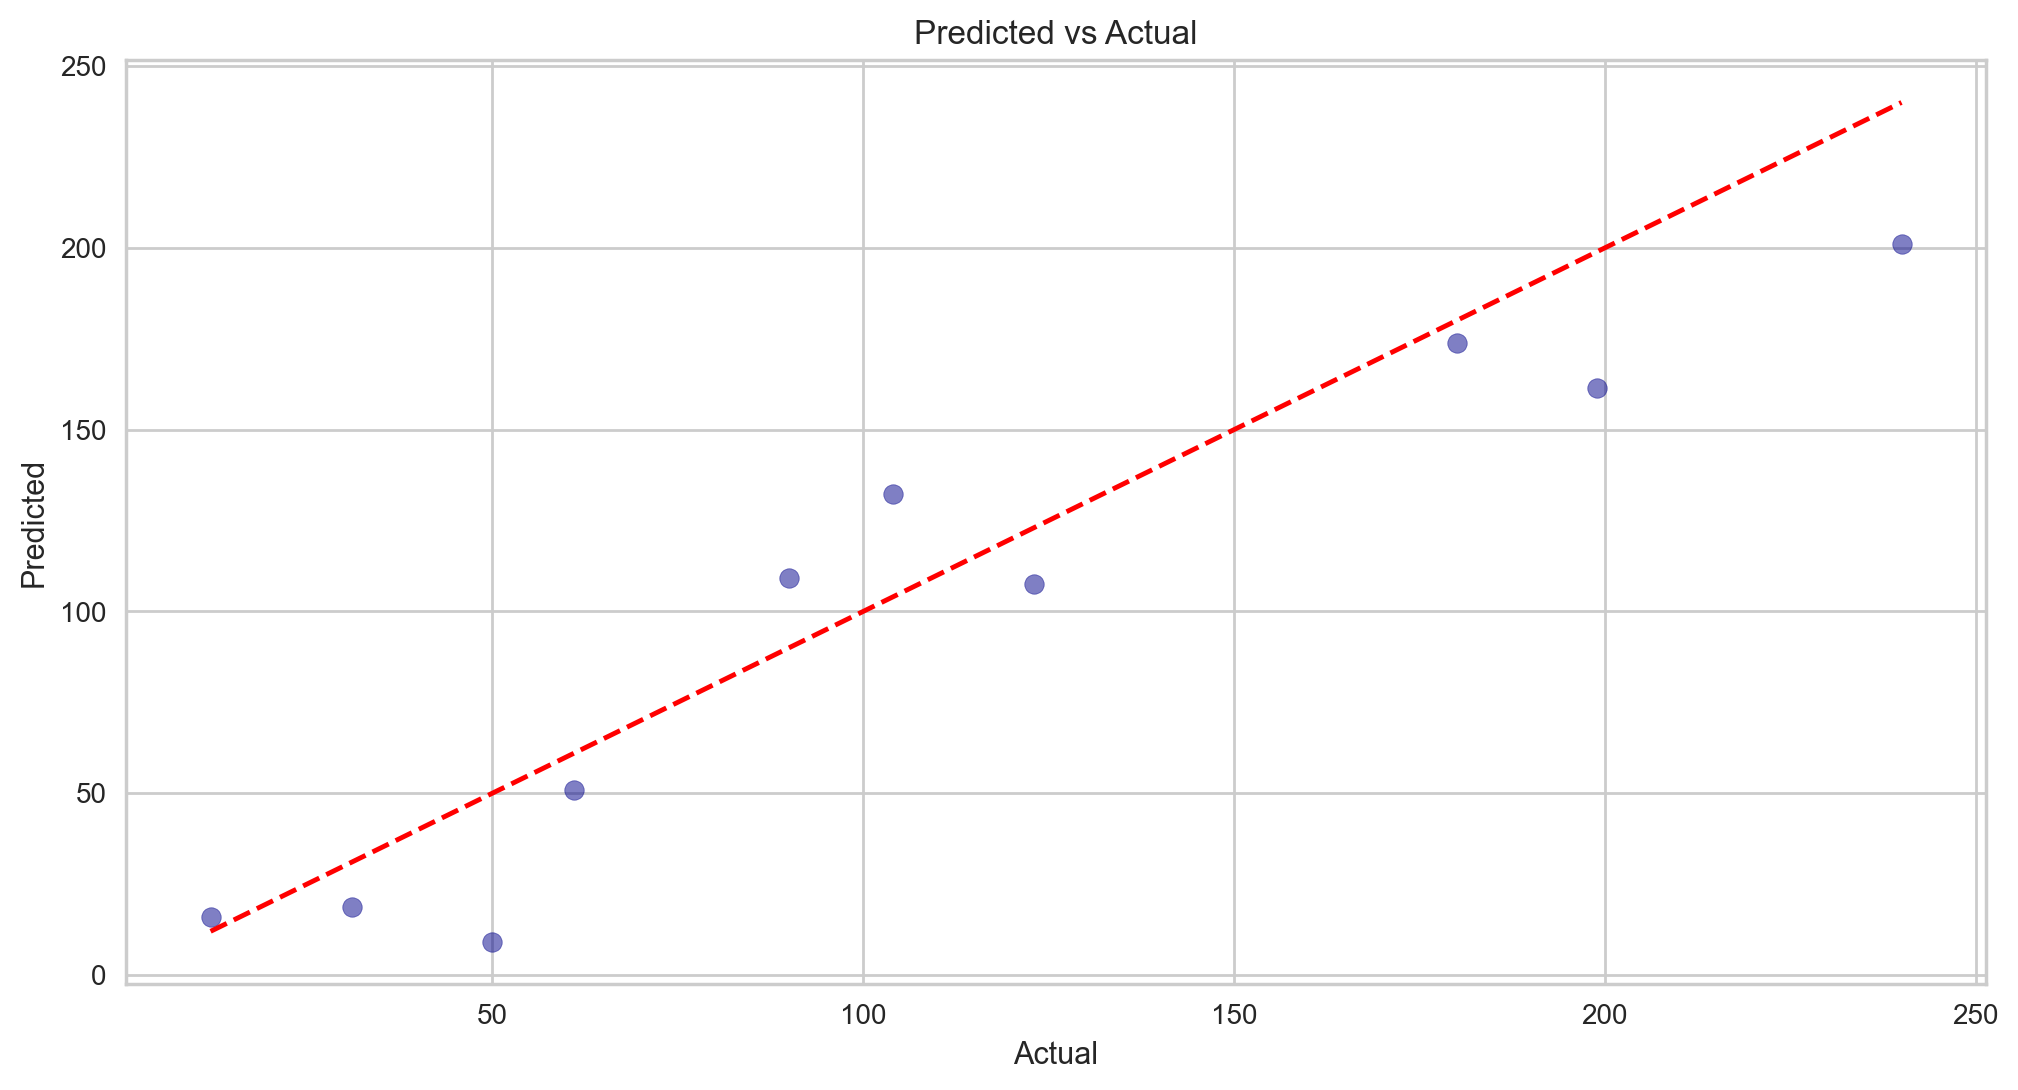

In [26]:
plt.figure(figsize=(12,6), dpi=200)
plt.scatter(y_test_exp, y_preds_exp, color='darkblue', alpha=0.5)
plt.plot([min(y_exp), max(y_exp)], [min(y_exp), max(y_exp)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.show()

### SVR Top Prediction errors

In [27]:
diff = np.abs(y_test - y_pred)

results_svr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Absolute Difference': diff})\
.sort_values('Absolute Difference', ascending=False)

In [28]:
results_svr.head(20)

,Actual,Predicted,Absolute Difference
beam_name,,,
I4_ B4481,20,308.185243,288.185243
I4_ B3901,15,271.170081,256.170081
I3_ B3136,15,251.462685,236.462685
I1_ B1303,15,239.679801,224.679801
I3_ B4429,15,202.869809,187.869809
I2_ B2620,20,207.189114,187.189114
I5_ B3988,20,195.466861,175.466861
I3_ B1774,15,184.824447,169.824447
I1_ B4429,15,184.450122,169.450122


In [29]:
df.loc[results_svr.index].head(20)

,length,concrete_area,concrete_cover,steel_area,frp_area,insulation_thickness,insulation_depth,conc_strength,steel_strength,frp_strength,glass_transition,thermal_conductivity,specific_heat,total_load,load_ratio,fire_resistance
beam_name,,,,,,,,,,,,,,,,
I4_ B4481,4700,157500,38,569.76,116.0,38.0,114.0,37.0,420,966,83,0.090,410000,40.96,55.03,20
I4_ B3901,4740,105000,25,593.87,127.5,38.0,75.0,36.0,453,1138,87,0.084,384000,43.25,48.84,15
I3_ B3136,4280,157500,38,593.87,55.2,25.0,38.0,29.0,451,4100,75,0.042,320000,58.46,46.39,15
I1_ B1303,1640,105000,38,379.84,263.9,19.0,114.0,29.0,416,1034,83,0.145,523000,127.10,44.40,15
I3_ B4429,5360,157500,25,593.87,285.6,38.0,62.5,31.0,451,1068,87,0.041,310000,52.98,42.37,15
I2_ B2620,4820,105000,38,395.91,43.2,25.0,114.0,39.0,446,4100,84,0.111,962000,31.37,44.72,20
I5_ B3988,1660,122500,25,379.84,263.9,38.0,75.0,31.0,437,1068,85,0.198,312000,108.20,45.95,20
I3_ B1774,4740,157500,25,854.64,85.8,19.0,25.0,30.0,420,4123,73,0.044,334000,63.40,45.21,15
I1_ B4429,5360,157500,25,593.87,285.6,38.0,62.5,31.0,451,1068,87,0.136,490000,52.98,42.37,15


---